# Distributions 

Usually in the ambient air, there are at least two modes of aerosol particles. Fine mode (150 nm mode) generated from atmospheric chemistry and combustion emissions. Coarse mode (10 microns mode) generated from windblown dust, sea salt, or wildfire ash.

So let's make a multi-modal distribution and propagate that forward in time.

## combined distributions 
As we saw in the mulit-mode distribution call above, you can use keywards to get multiple distributions. Let's see how those fine and coarse mode distributions interact.

In [ ]:
try:
    import particula, matplotlib
except ImportError:
    print("Setting up computational environment...")
    %pip install -U particula -qqq
    %pip install matplotlib -qqq

from particula import particle, rates
import numpy as np
from matplotlib import pyplot as plt
from particula.util.simple_solver import SimpleSolver
from particula.util.coagulation_rate import CoagulationRate
from particula.util.dimensionless_coagulation import full_coag
from particula.util.input_handling import in_time

In [19]:
ambient_dist = {
    "mode": [100e-9, 2000e-9], # 100 nm and 2000 nm 
    "nbins": 250, # cut the bins down for speed
    "nparticles": [1e7, 1e4], # 1e4 #
    "volume": 1e-6, # per 1e-6 m^3 (or 1 cc)
    "gsigma": [1.25,1.4], # relatively narrow
    "spacing": "logspace", # bin spacing,
}

ambient_dist = particle.Particle(**ambient_dist) 

#inital distribution coag kernel
coag_kernel = full_coag(radius=ambient_dist.particle_radius)
time_array = np.arange(0, 30*60, 1)

#setup the inital state of the distribution
problem = {
    "distribution": ambient_dist.particle_distribution(),
    "radius": ambient_dist.particle_radius,
    "kernel": coag_kernel,
    "tspan": time_array
}

problem2 = {
    "distribution": ambient_dist.particle_distribution(),
    "radius": ambient_dist.particle_radius,
    "kernel": coag_kernel*10, # 10x increase to approximate soot
    "tspan": time_array
}


#call the solver
solution = SimpleSolver(**problem).solution()
solution2 = SimpleSolver(**problem2).solution()




So we ran the simulation, and lets plot a couple slices for each. Solution 2 is an 10x increase in the coagulation kernel, which is a rough approximation for the coagulation enhancement due to a chain-like soot structure over the base spherical particle model.

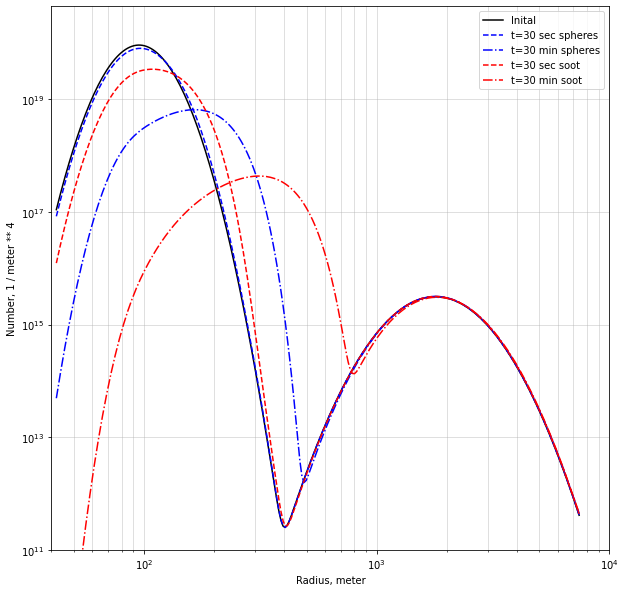

In [26]:
#plot
fig, ax= plt.subplots(1,1,figsize=[10,10])

radius = ambient_dist.particle_radius.to('nm').m
ax.loglog(radius, ambient_dist.particle_distribution().m, '-k', label='Inital')
ax.loglog(radius, solution.m[29,:], '--b', label='t=30 sec spheres')
ax.loglog(radius, solution.m[-1,:], '-.b', label='t=30 min spheres')

ax.loglog(radius, solution2.m[29,:], '--r', label='t=30 sec soot')
ax.loglog(radius, solution2.m[-1,:], '-.r', label='t=30 min soot')


ax.legend()
ax.set_ylim(bottom=1e11)
ax.set_xlim(left=40, right= 10000)
ax.set_ylabel(f"Number, {ambient_dist.particle_distribution().u}")
ax.set_xlabel(f"Radius, {ambient_dist.particle_radius.u}")
ax.grid(True, which='both', alpha=0.5)

## Number vs Time
Now lets plot the integrated number vs time. We should see the fine mode decrease, and the coarse mode increase a little depending on how fast the coagulational growth is moving the distribution. 

128


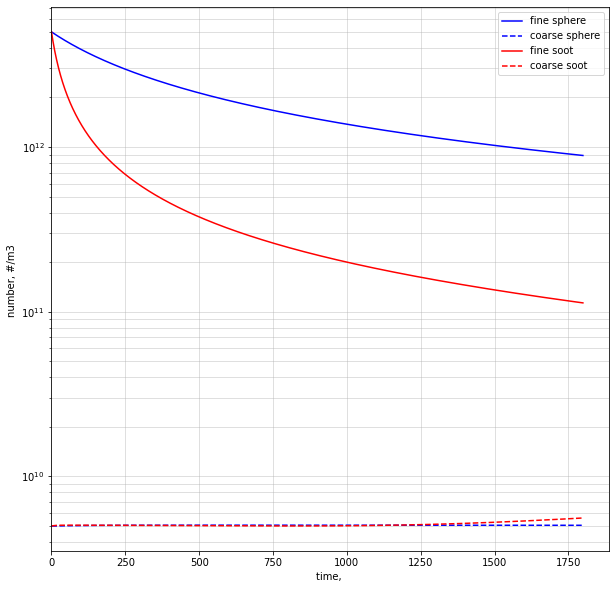

In [21]:
radius = ambient_dist.particle_radius.m
radius_withunits= ambient_dist.particle_radius
split = 600e-9 # fine to coarse cut off we are using.

split_index = np.argmin(np.abs(radius-split))
print(split_index)

fine_mode = np.zeros_like(time_array)
coarse_mode = np.zeros_like(time_array)

fine_mode2 = np.zeros_like(time_array)
coarse_mode2 = np.zeros_like(time_array)

fine_mode_vol = np.zeros_like(time_array)
coarse_mode_vol = np.zeros_like(time_array)

def pdf_total(radius, pdf_distribution):
    return np.trapz(y=pdf_distribution, x=radius)

def pdf_volume_total(radius, pdf_distribution):
    return np.trapz(y=pdf_distribution* 4/3 * np.pi * radius**3, x=radius)

for i, value in enumerate(time_array):
  fine_mode[i] = pdf_total(radius[0:split_index], solution.m[i, 0:split_index] )
  coarse_mode[i] = pdf_total(radius[split_index:-1], solution.m[i, split_index:-1] )
  fine_mode2[i] = pdf_total(radius[0:split_index], solution2.m[i, 0:split_index] )
  coarse_mode2[i] = pdf_total(radius[split_index:-1], solution2.m[i, split_index:-1] )

  fine_mode_vol[i] = pdf_volume_total(radius_withunits[0:split_index], solution[i, 0:split_index] )
  coarse_mode_vol[i] = pdf_volume_total(radius_withunits[split_index:-1], solution[i, split_index:-1] )

fig, ax= plt.subplots(1,1,figsize=[10,10])

ax.semilogy(time_array, fine_mode, '-b', label='fine sphere')
ax.semilogy(time_array, coarse_mode, '--b', label='coarse sphere')

ax.semilogy(time_array, fine_mode2, '-r', label='fine soot')
ax.semilogy(time_array, coarse_mode2, '--r', label='coarse soot')

ax.legend()
ax.set_xlim(left=0)
ax.set_ylabel(f"number, #/m3 ")
ax.set_xlabel(f"time, ")
ax.grid(True, which='both', alpha=0.5)

fig.savefig('coagulation_number.png')
fig.savefig('coagulation_number.pdf')

# Summary

So we covered how to make a distribution, and how to progress a distribution forward in time with coagulation. This is just one of the three key processes (nucleation, condensation, and coagulation) happening to particles in the atmosphere; all of which can be simulated with `Particula`! 